# Step 2: Select PSF Stars (RXJ1131)

目标：
- 读取 `j8oi74010_drc.fits`
- 自动检测星点候选
- 对候选星点生成 `100x100` cutout 并展示
- 仅在 notebook 中显示，不保存任何数据文件


In [1]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder


/home/skylee/anaconda3/lib/python3.12/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/skylee/anaconda3/lib/python3.12/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [2]:
# ---- Config ----
DATA_DIR = Path('../../Data/RXJ1131')
FITS_PATH = DATA_DIR / 'j8oi74010_drc.fits'
CUT_SIZE = 101                      # 101x101 (odd size for PSF kernel)
HALF = CUT_SIZE // 2
CUT_EXTRA = CUT_SIZE % 2
N_SHOW = 25                         # 展示前 25 颗（5x5）
N_COLS = 5                          # 每行 5 张
DAO_FWHM = 2.5
DAO_THRESHOLD_SIGMA = 10.0
MIN_SEP_PIX = 30.0                  # 去重最小间距

print('FITS_PATH =', FITS_PATH)
print('CUT_SIZE  =', CUT_SIZE)
print('N_SHOW    =', N_SHOW)


FITS_PATH = ../../Data/RXJ1131/j8oi74010_drc.fits
CUT_SIZE  = 101
N_SHOW    = 25


In [3]:
with fits.open(FITS_PATH, memmap=True) as hdul:
    if 'SCI' in hdul:
        data = np.array(hdul['SCI'].data, dtype=np.float64)
    else:
        data = np.array(hdul[0].data, dtype=np.float64)

ny, nx = data.shape
valid = np.isfinite(data)

mean, med, std = sigma_clipped_stats(data[valid], sigma=3.0, maxiters=8)
print('Image shape:', data.shape)
print('Sigma-clipped stats:', {'mean': float(mean), 'median': float(med), 'std': float(std)})


Image shape: (4476, 4243)
Sigma-clipped stats: {'mean': 0.0008132877635073201, 'median': 0.000633633288089186, 'std': 0.007514518900547751}


In [4]:
# ---- Star detection ----
finder = DAOStarFinder(
    fwhm=DAO_FWHM,
    threshold=DAO_THRESHOLD_SIGMA * std,
    exclude_border=True,
)

sources = finder(data - med)
if sources is None or len(sources) == 0:
    raise RuntimeError('No stars detected. Try reducing DAO_THRESHOLD_SIGMA.')

cand = pd.DataFrame(sources.as_array())

# 基础过滤：避免边缘（保证100x100能完整裁切）+ 基本形态约束
edge = HALF + 2
mask = (
    np.isfinite(cand['xcentroid'])
    & np.isfinite(cand['ycentroid'])
    & np.isfinite(cand['peak'])
    & np.isfinite(cand['flux'])
    & (cand['peak'] > 0)
    & (cand['xcentroid'] > edge)
    & (cand['xcentroid'] < nx - edge)
    & (cand['ycentroid'] > edge)
    & (cand['ycentroid'] < ny - edge)
    & (cand['sharpness'] > 0.15)
    & (cand['sharpness'] < 1.3)
    & (np.abs(cand['roundness1']) < 0.8)
    & (np.abs(cand['roundness2']) < 0.8)
)

cand = cand.loc[mask].copy()
cand = cand.sort_values('peak', ascending=False).reset_index(drop=True)

# 去重：按亮度优先，保留相互距离 >= MIN_SEP_PIX 的候选
picked = []
for _, r in cand.iterrows():
    x, y = float(r['xcentroid']), float(r['ycentroid'])
    if all(np.hypot(x - px, y - py) >= MIN_SEP_PIX for px, py in picked):
        picked.append((x, y))
    if len(picked) >= max(N_SHOW, 5):
        break

sel = []
for i, (x, y) in enumerate(picked, start=1):
    sel.append({'cand_id': i, 'x_pix': x, 'y_pix': y, 'x_pix_1based': x + 1.0, 'y_pix_1based': y + 1.0})

selected = pd.DataFrame(sel)

if len(selected) == 0:
    raise RuntimeError('No candidate left after filtering.')

print('Detected total =', len(sources))
print('After filter   =', len(cand))
print('Selected       =', len(selected))
selected.head(15)


Detected total = 1049
After filter   = 840
Selected       = 25


,cand_id,x_pix,y_pix,x_pix_1based,y_pix_1based
0,1,1573.569667,4333.098282,1574.569667,4334.098282
1,2,4140.330352,3377.484919,4141.330352,3378.484919
2,3,2142.551729,3409.042481,2143.551729,3410.042481
3,4,1458.125636,1898.299562,1459.125636,1899.299562
4,5,3620.406115,4340.616522,3621.406115,4341.616522
5,6,1141.123703,3422.022008,1142.123703,3423.022008
6,7,2259.447096,1475.702676,2260.447096,1476.702676
7,8,3280.424991,683.120415,3281.424991,684.120415
8,9,67.593642,1188.071265,68.593642,1189.071265
9,10,2095.495920,3416.799546,2096.495920,3417.799546


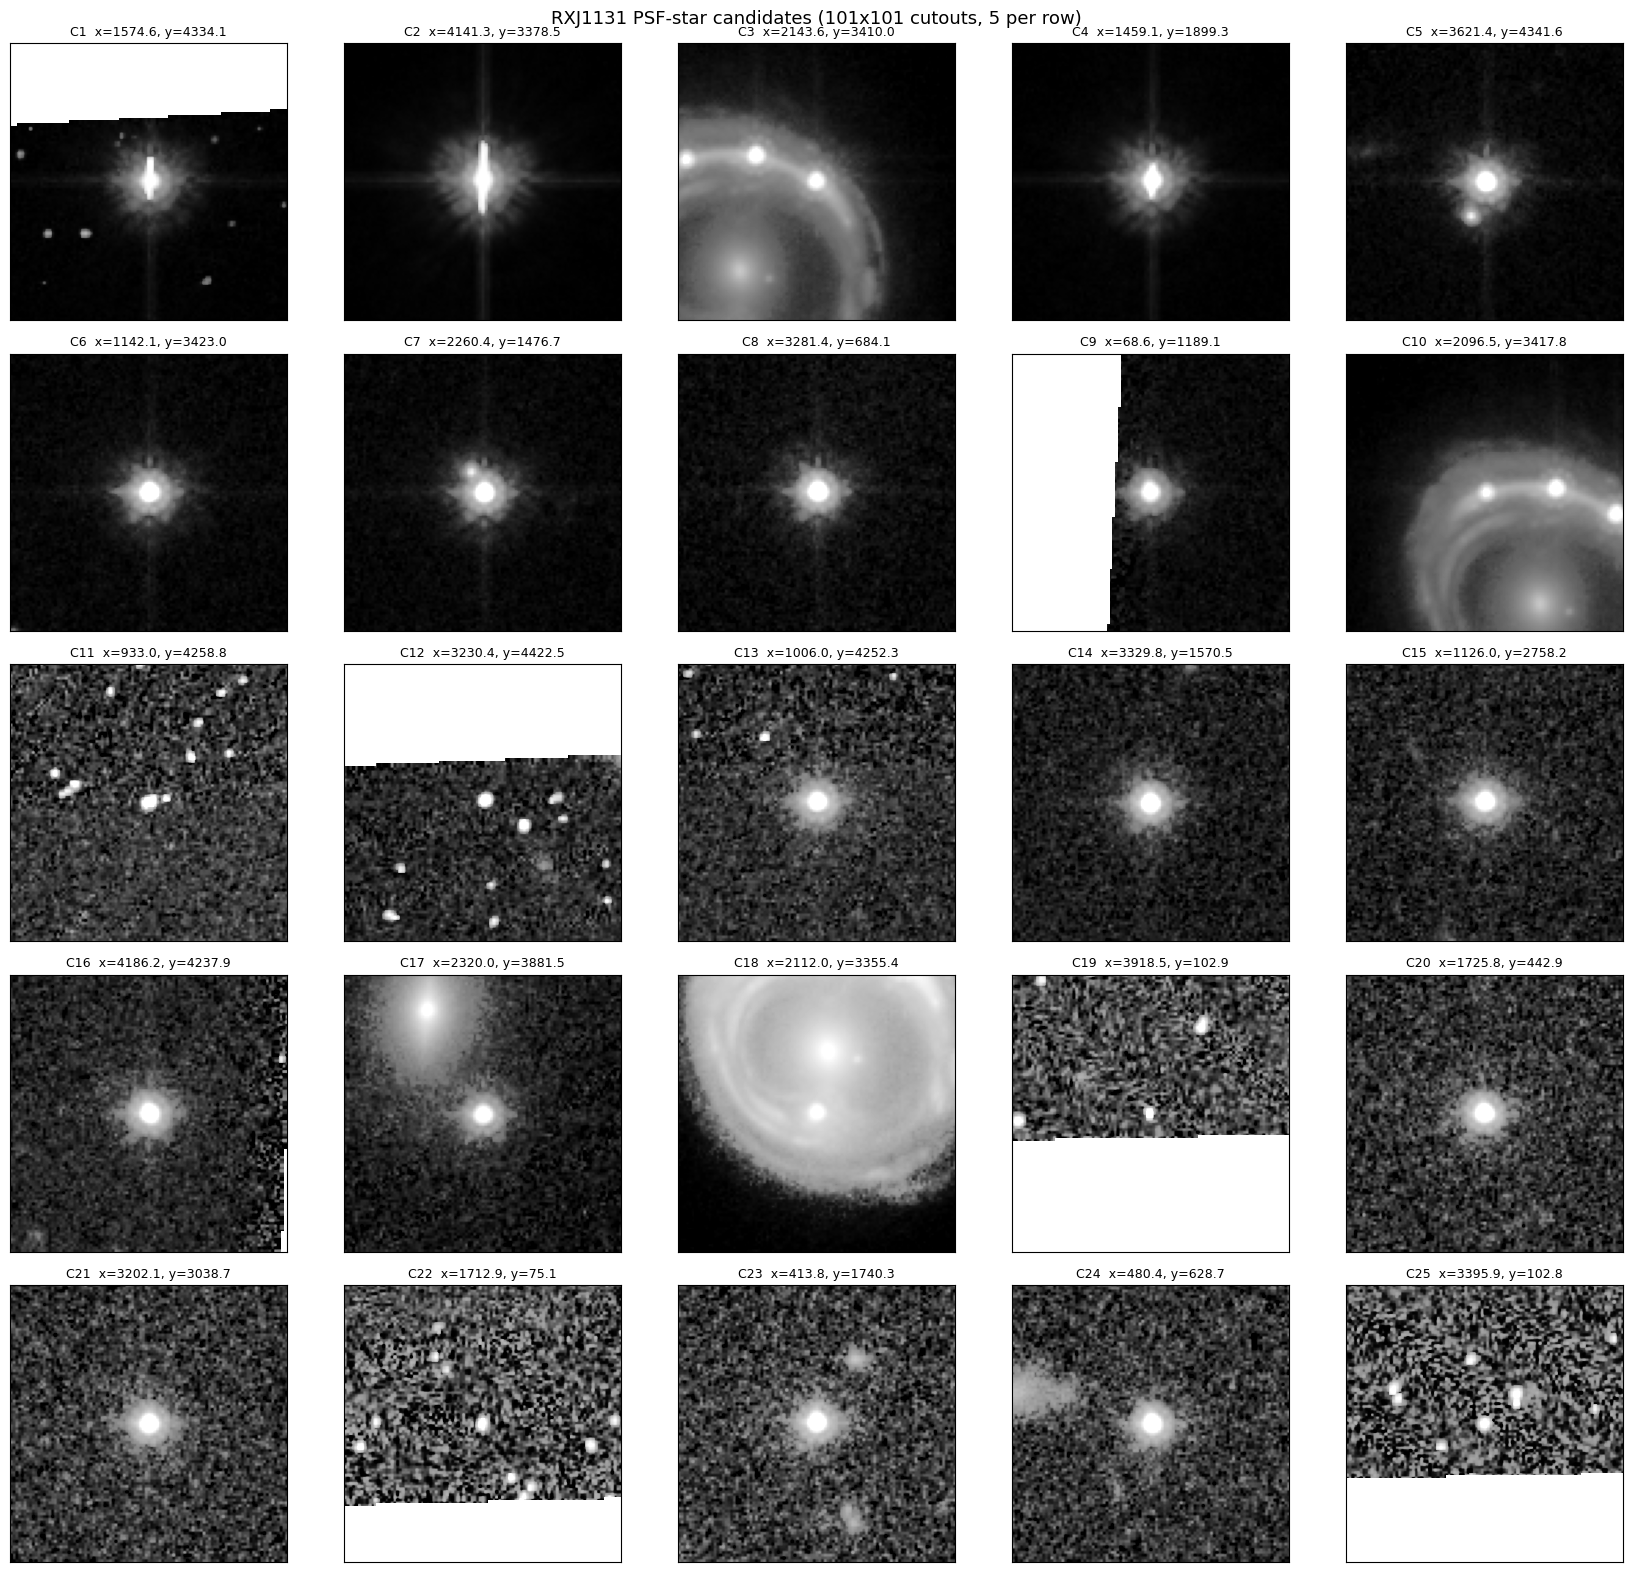

In [5]:
# ---- Show 100x100 cutouts (one row has 5 images) ----
n_show = min(N_SHOW, len(selected))
n_rows = math.ceil(n_show / N_COLS)

fig, axes = plt.subplots(n_rows, N_COLS, figsize=(3.4 * N_COLS, 3.2 * n_rows))
if n_rows == 1:
    axes = np.array(axes).reshape(1, -1)

for i in range(n_show):
    r = selected.iloc[i]
    x = int(round(r['x_pix']))
    y = int(round(r['y_pix']))
    x1, x2 = x - HALF, x + HALF + CUT_EXTRA
    y1, y2 = y - HALF, y + HALF + CUT_EXTRA

    cut = data[y1:y2, x1:x2].copy()

    # 局部背景扣除（仅用于展示）
    k = 8
    border = np.hstack([
        cut[:k, :].ravel(),
        cut[-k:, :].ravel(),
        cut[:, :k].ravel(),
        cut[:, -k:].ravel(),
    ])
    bkg = np.nanmedian(border[np.isfinite(border)])
    cut_show = cut - bkg

    vmin = np.nanpercentile(cut_show, 5)
    vmax = np.nanpercentile(cut_show, 99.7)
    if not np.isfinite(vmin):
        vmin = 0.0
    if not np.isfinite(vmax) or vmax <= vmin:
        vmax = vmin + 1.0

    rr = i // N_COLS
    cc = i % N_COLS
    ax = axes[rr, cc]
    norm = colors.SymLogNorm(linthresh=max(np.nanstd(cut_show) * 0.05, 1e-3), vmin=vmin, vmax=vmax)
    ax.imshow(cut_show, origin='lower', cmap='gray', norm=norm)
    ax.set_title(f"C{int(r['cand_id'])}  x={r['x_pix_1based']:.1f}, y={r['y_pix_1based']:.1f}", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

# 隐藏空白子图
for j in range(n_show, n_rows * N_COLS):
    rr = j // N_COLS
    cc = j % N_COLS
    axes[rr, cc].axis('off')

fig.suptitle(f'RXJ1131 PSF-star candidates ({CUT_SIZE}x{CUT_SIZE} cutouts, {N_COLS} per row)', fontsize=13)
plt.tight_layout()
plt.show()


In [6]:
# 可选：打印前N个候选坐标，便于后续挑选
selected.iloc[:N_SHOW]


,cand_id,x_pix,y_pix,x_pix_1based,y_pix_1based
0,1,1573.569667,4333.098282,1574.569667,4334.098282
1,2,4140.330352,3377.484919,4141.330352,3378.484919
2,3,2142.551729,3409.042481,2143.551729,3410.042481
3,4,1458.125636,1898.299562,1459.125636,1899.299562
4,5,3620.406115,4340.616522,3621.406115,4341.616522
5,6,1141.123703,3422.022008,1142.123703,3423.022008
6,7,2259.447096,1475.702676,2260.447096,1476.702676
7,8,3280.424991,683.120415,3281.424991,684.120415
8,9,67.593642,1188.071265,68.593642,1189.071265
9,10,2095.495920,3416.799546,2096.495920,3417.799546


Saved 8 FITS files into: psf_data
 - C06_x1142_y3423_SCIERR.fits
 - C08_x3281_y684_SCIERR.fits
 - C15_x1126_y2758_SCIERR.fits
 - C16_x4186_y4238_SCIERR.fits
 - C20_x1726_y443_SCIERR.fits
 - C21_x3202_y3039_SCIERR.fits
 - C04_x1459_y1899_SCIERR.fits
 - C07_x2260_y1477_SCIERR.fits


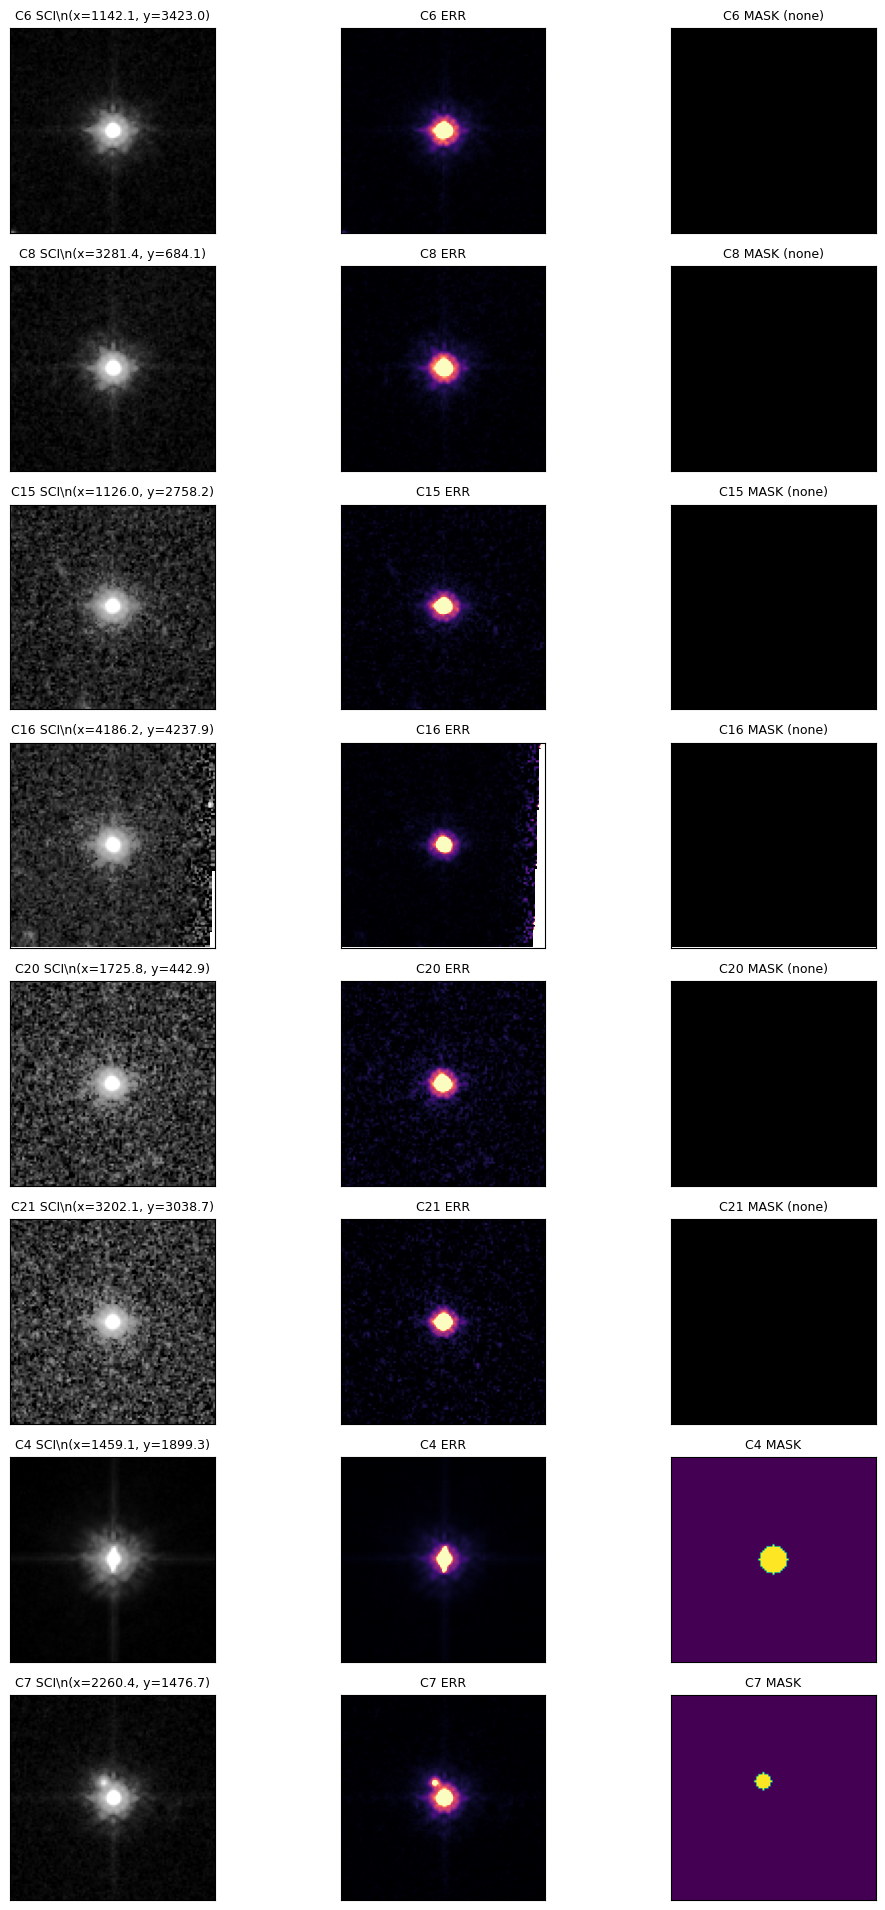

In [7]:

# ---- Save selected PSF cutouts to FITS (SCI + ERR; C4/C7 include MASK) ----
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

# IDs requested by user
save_ids = [6, 8, 15, 16, 20, 21, 4, 7]

# mask config for special stars (cutout-relative coordinates)
# center uses cutout center; C7 uses center + (dx=-5, dy=+8)
special_masks = {
    4: {'kind': 'center_circle', 'radius': 7.0},
    7: {'kind': 'offset_circle', 'radius': 4.0, 'dx': -5.0, 'dy': 8.0},
}

out_dir = Path('./psf_data')
out_dir.mkdir(parents=True, exist_ok=True)

with fits.open(FITS_PATH, memmap=True) as hdul:
    sci_full = np.array(hdul['SCI'].data if 'SCI' in hdul else hdul[0].data, dtype=np.float64)
    wht_full = np.array(hdul['WHT'].data, dtype=np.float64)

ny, nx = sci_full.shape
half = CUT_SIZE // 2
extra = CUT_SIZE % 2

# lookup selected by cand_id
sel_map = {int(r.cand_id): r for r in selected.itertuples(index=False)}

saved = []
show_items = []

for cid in save_ids:
    if cid not in sel_map:
        print(f'[WARN] C{cid} not found in selected table, skipped.')
        continue

    row = sel_map[cid]
    x = int(round(float(row.x_pix)))
    y = int(round(float(row.y_pix)))

    x1, x2 = x - half, x + half + extra
    y1, y2 = y - half, y + half + extra

    if x1 < 0 or y1 < 0 or x2 > nx or y2 > ny:
        print(f'[WARN] C{cid} cutout out of bounds, skipped.')
        continue

    sci = sci_full[y1:y2, x1:x2].copy()
    wht = wht_full[y1:y2, x1:x2].copy()

    # background sigma from four corners (5x5)
    k = 5
    corners = [
        sci[:k, :k],
        sci[:k, -k:],
        sci[-k:, :k],
        sci[-k:, -k:],
    ]
    bg = np.concatenate([c.ravel() for c in corners])
    bg = bg[np.isfinite(bg)]
    bg_med = float(np.median(bg)) if bg.size else 0.0
    bg_mad = float(np.median(np.abs(bg - bg_med))) if bg.size else 0.0
    bg_sigma = 1.4826 * bg_mad

    # ERR from WHT (effective exposure map) + background term
    err = np.full_like(sci, np.nan, dtype=np.float64)
    good = np.isfinite(sci) & np.isfinite(wht) & (wht > 0)
    var_poisson = np.zeros_like(sci, dtype=np.float64)
    var_poisson[good] = np.clip(sci[good], 0.0, None) / wht[good]
    err[good] = np.sqrt(var_poisson[good] + bg_sigma**2)

    # Optional mask for C4/C7
    mask = None
    if cid in special_masks:
        yy, xx = np.indices(sci.shape, dtype=np.float64)
        cx = (CUT_SIZE - 1) / 2.0
        cy = (CUT_SIZE - 1) / 2.0
        cfg = special_masks[cid]

        if cfg['kind'] == 'center_circle':
            mx, my = cx, cy
            rr = cfg['radius']
        else:
            mx = cx + cfg['dx']
            my = cy + cfg['dy']
            rr = cfg['radius']

        mask = ((xx - mx)**2 + (yy - my)**2) <= rr**2

    x1b = float(row.x_pix_1based)
    y1b = float(row.y_pix_1based)
    tag = f'C{cid:02d}_x{int(round(x1b))}_y{int(round(y1b))}'
    out_fits = out_dir / f'{tag}_SCIERR.fits'

    phdr = fits.Header()
    phdr['EXTNAME'] = 'SCI'
    phdr['CANDID'] = cid
    phdr['XPIX1B'] = (x1b, 'Candidate x position (1-based, full frame)')
    phdr['YPIX1B'] = (y1b, 'Candidate y position (1-based, full frame)')
    phdr['CUTSIZE'] = CUT_SIZE
    phdr['BKGMED'] = (bg_med, 'Corner-based background median [e-/s]')
    phdr['BKGSIG'] = (bg_sigma, 'Corner-based background sigma [e-/s]')

    ehdr = fits.Header()
    ehdr['EXTNAME'] = 'ERR'
    ehdr['BUNIT'] = 'ELECTRONS/S'
    ehdr['ERRMOD'] = 'SQRT(MAX(SCI,0)/WHT + BKGSIG^2)'

    hdus = [
        fits.PrimaryHDU(data=sci.astype(np.float32), header=phdr),
        fits.ImageHDU(data=err.astype(np.float32), header=ehdr),
    ]

    if mask is not None:
        mhdr = fits.Header()
        mhdr['EXTNAME'] = 'MASK'
        mhdr['MASKVAL'] = '1=masked,0=unmasked'
        if cid == 4:
            mhdr['MSKTYP'] = 'CIRCLE_CENTER_R7'
        elif cid == 7:
            mhdr['MSKTYP'] = 'CIRCLE_OFF_DX-5_DY+8_R4'
        hdus.append(fits.ImageHDU(data=mask.astype(np.uint8), header=mhdr))

    fits.HDUList(hdus).writeto(out_fits, overwrite=True)

    saved.append(out_fits)
    show_items.append((cid, sci, err, mask, x1b, y1b))

print(f'Saved {len(saved)} FITS files into: {out_dir}')
for p in saved:
    print(' -', p.name)

# ---- quick display: selected PSF + mask ----
n = len(show_items)
fig, axes = plt.subplots(n, 3, figsize=(11, max(3, 2.4*n)), squeeze=False)
for i, (cid, sci, err, mask, x1b, y1b) in enumerate(show_items):
    # SCI
    vmin = np.nanpercentile(sci, 5)
    vmax = np.nanpercentile(sci, 99.7)
    if not np.isfinite(vmin):
        vmin = 0.0
    if not np.isfinite(vmax) or vmax <= vmin:
        vmax = vmin + 1.0

    ax0 = axes[i, 0]
    ax0.imshow(sci, origin='lower', cmap='gray', norm=colors.SymLogNorm(linthresh=max(np.nanstd(sci)*0.05, 1e-3), vmin=vmin, vmax=vmax))
    ax0.set_title(f'C{cid} SCI\\n(x={x1b:.1f}, y={y1b:.1f})', fontsize=9)
    ax0.set_xticks([]); ax0.set_yticks([])

    # ERR
    ax1 = axes[i, 1]
    finite_err = err[np.isfinite(err)]
    if finite_err.size:
        evmin = np.nanpercentile(finite_err, 5)
        evmax = np.nanpercentile(finite_err, 99.5)
    else:
        evmin, evmax = 0.0, 1.0
    if not np.isfinite(evmax) or evmax <= evmin:
        evmax = evmin + 1.0
    ax1.imshow(err, origin='lower', cmap='magma', vmin=evmin, vmax=evmax)
    ax1.set_title(f'C{cid} ERR', fontsize=9)
    ax1.set_xticks([]); ax1.set_yticks([])

    # MASK
    ax2 = axes[i, 2]
    if mask is None:
        ax2.imshow(np.zeros_like(sci), origin='lower', cmap='gray', vmin=0, vmax=1)
        ax2.set_title(f'C{cid} MASK (none)', fontsize=9)
    else:
        ax2.imshow(mask.astype(float), origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax2.set_title(f'C{cid} MASK', fontsize=9)
    ax2.set_xticks([]); ax2.set_yticks([])

plt.tight_layout()
plt.show()
